In [1]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### **ARIMA**

In [2]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime


def arima_test(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-02-11/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx']


### **Data Stacking**

In [4]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

ohlcv.head() :
                             open     high      low    close     volume
2020-04-17 00:29:59.999  7019.80  7040.00  7010.00  7023.00   7828.383
2020-04-17 00:59:59.999  7023.00  7064.00  7000.00  7040.85  12396.717
2020-04-17 01:29:59.999  7041.51  7059.00  6958.39  6986.03  13256.941
2020-04-17 01:59:59.999  6986.40  7009.00  6950.00  7002.41  12065.060
2020-04-17 02:29:59.999  7002.41  7023.45  6982.05  7000.39   5898.852
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

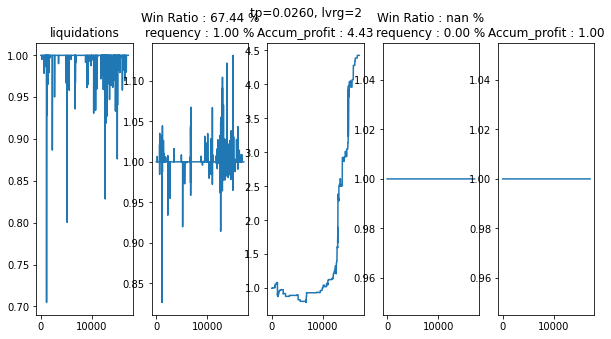

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (172, 45, 6)


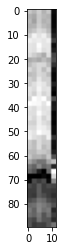

input_x.shape : (172, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (172, 1)
input_ud.shape : (172, 1)
input_index.shape : (172, 1)
ohlcv.head() :
                            open    high     low   close      volume
2020-04-17 00:29:59.999  170.64  171.70  170.51  171.43   31553.530
2020-04-17 00:59:59.999  171.39  172.53  169.69  172.45   83646.710
2020-04-17 01:29:59.999  172.44  173.10  170.00  170.08  109577.681
2020-04-17 01:59:59.999  170.05  170.96  169.37  170.69   46913.210
2020-04-17 02:29:59.999  170.69  171.08  170.00  170.48   41285.721
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

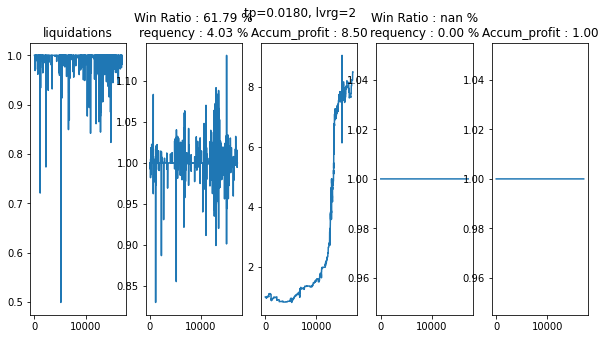

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (691, 45, 6)


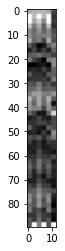

input_x.shape : (691, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (691, 1)
input_ud.shape : (691, 1)
input_index.shape : (691, 1)
total_x.shape : (863, 90, 12, 3)
total_pr.shape : (863, 1)
total_ud.shape : (863, 1)
prev_index.shape : (863, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-04-17 00:29:59.999  229.93  231.42  229.87  230.69   5612.531
2020-04-17 00:59:59.999  230.69  233.46  228.90  232.38   9079.532
2020-04-17 01:29:59.999  232.37  233.57  228.50  228.98  12368.271
2020-04-17 01:59:59.999  229.00  229.54  227.62  228.44   7766.550
2020-04-17 02:29:59.999  228.46  229.29  228.01  228.91   5366.285
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BCHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

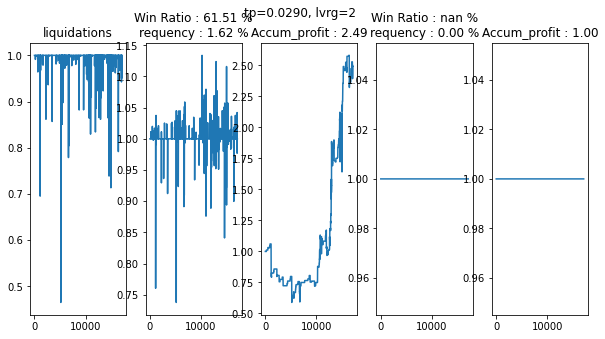

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (278, 45, 6)


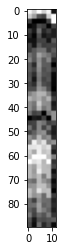

input_x.shape : (278, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (278, 1)
input_ud.shape : (278, 1)
input_index.shape : (278, 1)
total_x.shape : (1141, 90, 12, 3)
total_pr.shape : (1141, 1)
total_ud.shape : (1141, 1)
prev_index.shape : (1141, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-04-17 00:29:59.999  0.1893  0.1897  0.1891  0.1895  1432127.2
2020-04-17 00:59:59.999  0.1894  0.1903  0.1885  0.1899  2470822.4
2020-04-17 01:29:59.999  0.1900  0.1906  0.1880  0.1882  3192860.4
2020-04-17 01:59:59.999  0.1881  0.1888  0.1873  0.1886  2087213.8
2020-04-17 02:29:59.999  0.1886  0.1889  0.1880  0.1884   862378.1
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XRPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

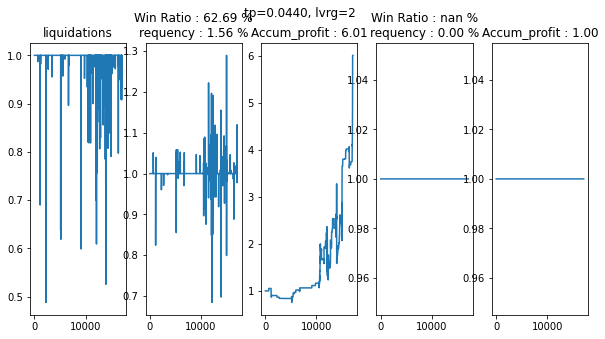

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (268, 45, 6)


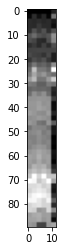

input_x.shape : (268, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (268, 1)
input_ud.shape : (268, 1)
input_index.shape : (268, 1)
total_x.shape : (1409, 90, 12, 3)
total_pr.shape : (1409, 1)
total_ud.shape : (1409, 1)
prev_index.shape : (1409, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-04-17 00:29:59.999  2.644  2.654  2.642  2.650  219740.0
2020-04-17 00:59:59.999  2.650  2.671  2.635  2.669  285942.3
2020-04-17 01:29:59.999  2.669  2.690  2.632  2.640  849475.4
2020-04-17 01:59:59.999  2.639  2.647  2.625  2.644  374129.2
2020-04-17 02:29:59.999  2.643  2.647  2.634  2.640  109641.5
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 EOSUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

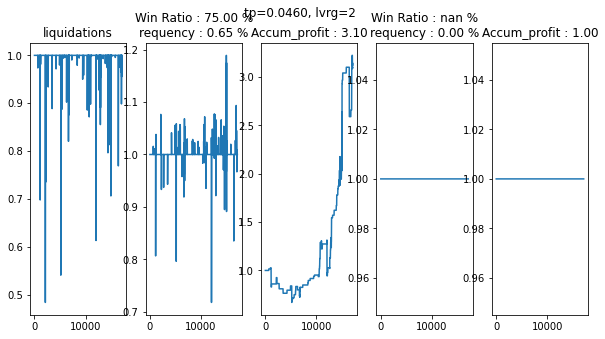

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (112, 45, 6)


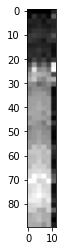

input_x.shape : (112, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (112, 1)
input_ud.shape : (112, 1)
input_index.shape : (112, 1)
total_x.shape : (1521, 90, 12, 3)
total_pr.shape : (1521, 1)
total_ud.shape : (1521, 1)
prev_index.shape : (1521, 1)
ohlcv.head() :
                           open   high    low  close     volume
2020-04-17 00:29:59.999  42.34  42.45  42.27  42.35  10243.724
2020-04-17 00:59:59.999  42.33  42.62  42.13  42.58  16344.677
2020-04-17 01:29:59.999  42.55  42.75  42.13  42.16  26915.769
2020-04-17 01:59:59.999  42.16  42.36  42.01  42.29  16206.903
2020-04-17 02:29:59.999  42.29  42.38  42.17  42.28   4570.908
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 LTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

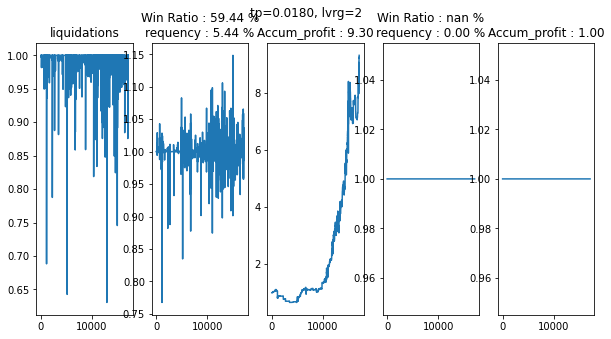

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (932, 45, 6)


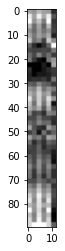

input_x.shape : (932, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (932, 1)
input_ud.shape : (932, 1)
input_index.shape : (932, 1)
total_x.shape : (2453, 90, 12, 3)
total_pr.shape : (2453, 1)
total_ud.shape : (2453, 1)
prev_index.shape : (2453, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-04-17 00:29:59.999  5.384  5.401  5.373  5.385  34829.13
2020-04-17 00:59:59.999  5.386  5.424  5.361  5.412  72836.80
2020-04-17 01:29:59.999  5.412  5.431  5.354  5.363  74427.73
2020-04-17 01:59:59.999  5.361  5.372  5.338  5.359  43664.10
2020-04-17 02:29:59.999  5.360  5.370  5.340  5.358  24787.26
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ETCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

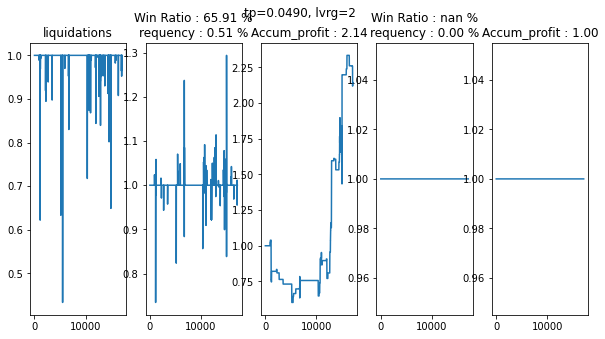

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (88, 45, 6)


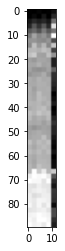

input_x.shape : (88, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (88, 1)
input_ud.shape : (88, 1)
input_index.shape : (88, 1)
total_x.shape : (2541, 90, 12, 3)
total_pr.shape : (2541, 1)
total_ud.shape : (2541, 1)
prev_index.shape : (2541, 1)
ohlcv.head() :
                           open   high    low  close      volume
2020-04-17 00:29:59.999  3.377  3.395  3.367  3.383  1034111.20
2020-04-17 00:59:59.999  3.384  3.400  3.366  3.393   730728.13
2020-04-17 01:29:59.999  3.390  3.420  3.349  3.355  1633257.50
2020-04-17 01:59:59.999  3.354  3.374  3.335  3.362   854946.07
2020-04-17 02:29:59.999  3.362  3.373  3.342  3.359   456942.88
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 LINKUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

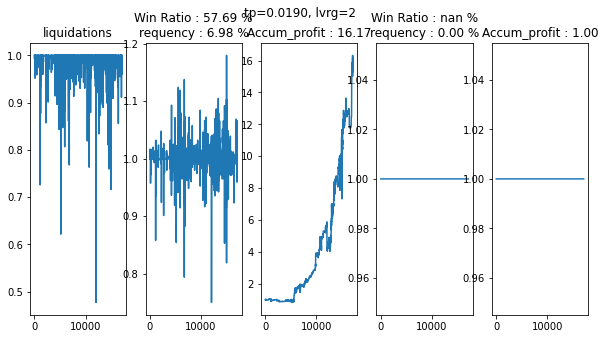

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (1194, 45, 6)


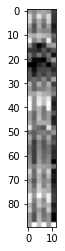

input_x.shape : (1194, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1194, 1)
input_ud.shape : (1194, 1)
input_index.shape : (1194, 1)
total_x.shape : (3735, 90, 12, 3)
total_pr.shape : (3735, 1)
total_ud.shape : (3735, 1)
prev_index.shape : (3735, 1)
ohlcv.head() :
                             open     high      low    close   volume
2020-04-17 00:29:59.999  0.04858  0.04889  0.04857  0.04880   888461
2020-04-17 00:59:59.999  0.04880  0.04921  0.04849  0.04920  3749767
2020-04-17 01:29:59.999  0.04916  0.04939  0.04851  0.04856  3559523
2020-04-17 01:59:59.999  0.04854  0.04874  0.04831  0.04866  1937389
2020-04-17 02:29:59.999  0.04863  0.04873  0.04841  0.04852   972672
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XLMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

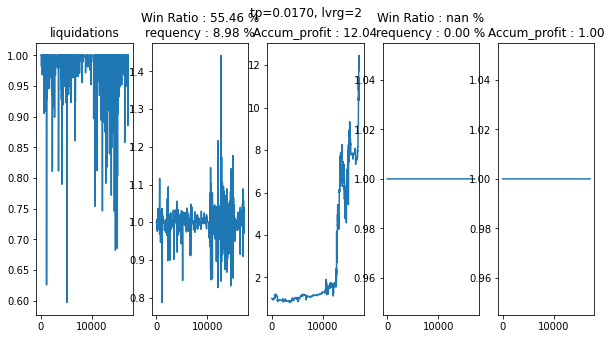

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (1538, 45, 6)


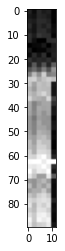

input_x.shape : (1538, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1538, 1)
input_ud.shape : (1538, 1)
input_index.shape : (1538, 1)
total_x.shape : (5273, 90, 12, 3)
total_pr.shape : (5273, 1)
total_ud.shape : (5273, 1)
prev_index.shape : (5273, 1)
ohlcv.head() :
                             open     high      low    close   volume
2020-04-17 00:29:59.999  0.03373  0.03380  0.03371  0.03377  1032447
2020-04-17 00:59:59.999  0.03376  0.03393  0.03360  0.03391  3690223
2020-04-17 01:29:59.999  0.03393  0.03408  0.03354  0.03360  3251104
2020-04-17 01:59:59.999  0.03357  0.03373  0.03341  0.03365  3441250
2020-04-17 02:29:59.999  0.03365  0.03371  0.03347  0.03360  1209095
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ADAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

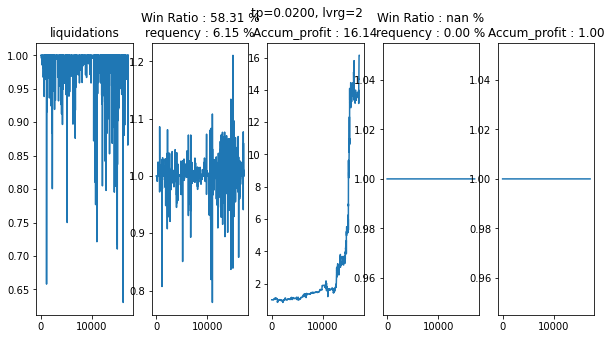

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (1053, 45, 6)


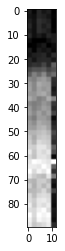

input_x.shape : (1053, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1053, 1)
input_ud.shape : (1053, 1)
input_index.shape : (1053, 1)
total_x.shape : (6326, 90, 12, 3)
total_pr.shape : (6326, 1)
total_ud.shape : (6326, 1)
prev_index.shape : (6326, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-04-17 00:29:59.999  56.00  56.15  55.94  56.04   829.347
2020-04-17 00:59:59.999  56.06  56.21  55.75  56.07  4251.815
2020-04-17 01:29:59.999  56.07  56.22  55.40  55.42  3749.086
2020-04-17 01:59:59.999  55.44  55.83  55.15  55.77  3401.925
2020-04-17 02:29:59.999  55.77  55.96  55.61  55.75  1132.604
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XMRUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

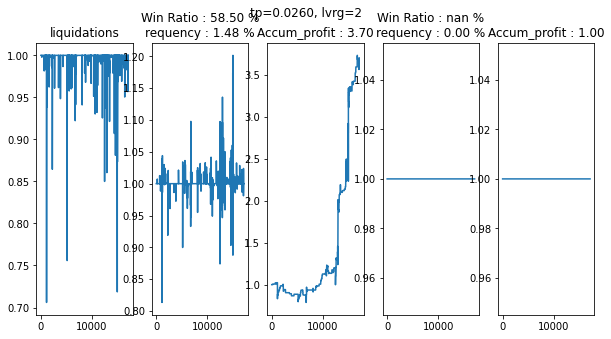

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (253, 45, 6)


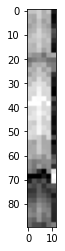

input_x.shape : (253, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (253, 1)
input_ud.shape : (253, 1)
input_index.shape : (253, 1)
total_x.shape : (6579, 90, 12, 3)
total_pr.shape : (6579, 1)
total_ud.shape : (6579, 1)
prev_index.shape : (6579, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-07-21 18:29:59.999  1.4800  1.6583  1.4800  1.6128  1280481.5
2020-07-21 18:59:59.999  1.6134  1.6233  1.5698  1.5900   591016.9
2020-07-21 19:29:59.999  1.5910  1.5910  1.5203  1.5210   642011.2
2020-07-21 19:59:59.999  1.5218  1.5482  1.4910  1.4916   575175.7
2020-07-21 20:29:59.999  1.4916  1.5435  1.4857  1.5265   481233.3
ohlcv.index[0] : 2020-07-21 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 SXPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

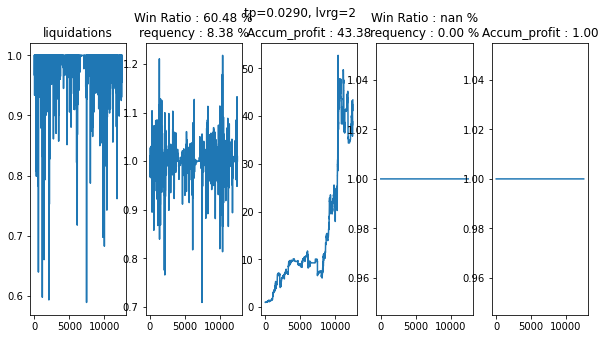

len(ohlc) : 12533
long_ep.shape : (12533, 1)
len(pr_list) : 12533
np.array(data_x).shape : (1046, 45, 6)


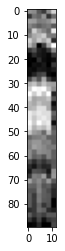

input_x.shape : (1046, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1046, 1)
input_ud.shape : (1046, 1)
input_index.shape : (1046, 1)
total_x.shape : (7625, 90, 12, 3)
total_pr.shape : (7625, 1)
total_ud.shape : (7625, 1)
prev_index.shape : (7625, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-07-28 16:29:59.999  2.5890  2.5900  2.4400  2.5474  258871.6
2020-07-28 16:59:59.999  2.5455  2.7391  2.5381  2.6491  414410.9
2020-07-28 17:29:59.999  2.6495  2.6950  2.5986  2.6270  336409.2
2020-07-28 17:59:59.999  2.6202  2.6280  2.5500  2.5733  302425.4
2020-07-28 18:29:59.999  2.5709  2.5908  2.5129  2.5205  156145.4
ohlcv.index[0] : 2020-07-28 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 KAVAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

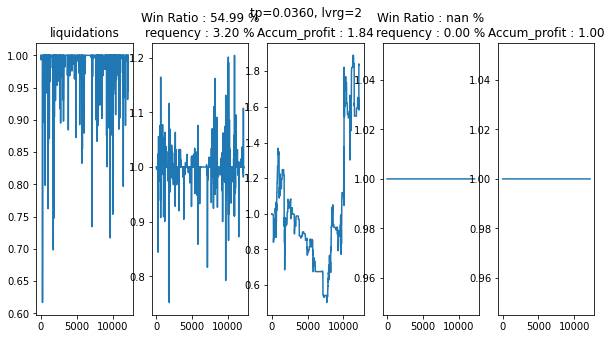

len(ohlc) : 12201
long_ep.shape : (12201, 1)
len(pr_list) : 12201
np.array(data_x).shape : (391, 45, 6)


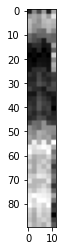

input_x.shape : (391, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (391, 1)
input_ud.shape : (391, 1)
input_index.shape : (391, 1)
total_x.shape : (8016, 90, 12, 3)
total_pr.shape : (8016, 1)
total_ud.shape : (8016, 1)
prev_index.shape : (8016, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-07-29 16:29:59.999  3.8400  3.8541  3.7885  3.8409  282793.6
2020-07-29 16:59:59.999  3.8408  3.9600  3.8405  3.9374  325082.8
2020-07-29 17:29:59.999  3.9373  3.9893  3.9162  3.9664  214068.2
2020-07-29 17:59:59.999  3.9655  3.9678  3.8900  3.9152  192810.7
2020-07-29 18:29:59.999  3.9157  3.9157  3.8400  3.8640  154682.0
ohlcv.index[0] : 2020-07-29 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BANDUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

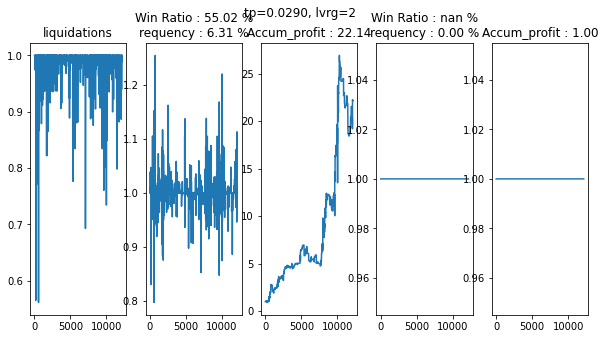

len(ohlc) : 12153
long_ep.shape : (12153, 1)
len(pr_list) : 12153
np.array(data_x).shape : (767, 45, 6)


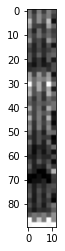

input_x.shape : (767, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (767, 1)
input_ud.shape : (767, 1)
input_index.shape : (767, 1)
total_x.shape : (8783, 90, 12, 3)
total_pr.shape : (8783, 1)
total_ud.shape : (8783, 1)
prev_index.shape : (8783, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-04-17 00:29:59.999  75.15  75.65  75.09  75.47  2194.988
2020-04-17 00:59:59.999  75.46  75.81  74.96  75.78  2250.993
2020-04-17 01:29:59.999  75.78  76.00  74.77  74.80  7274.975
2020-04-17 01:59:59.999  74.80  75.13  74.53  75.06  1377.859
2020-04-17 02:29:59.999  75.04  75.28  74.86  75.06   977.188
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 DASHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

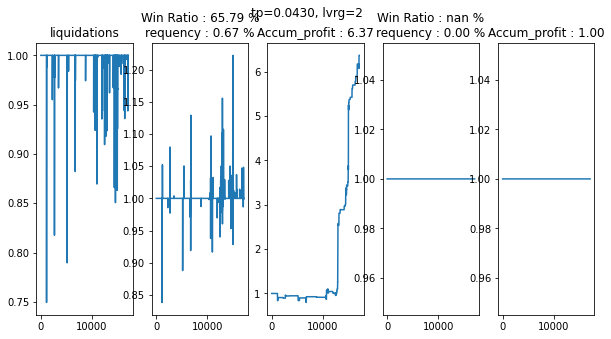

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (114, 45, 6)


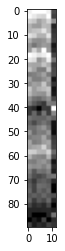

input_x.shape : (114, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (114, 1)
input_ud.shape : (114, 1)
input_index.shape : (114, 1)
total_x.shape : (8897, 90, 12, 3)
total_pr.shape : (8897, 1)
total_ud.shape : (8897, 1)
prev_index.shape : (8897, 1)
ohlcv.head() :
                           open   high    low  close     volume
2020-04-17 00:29:59.999  38.71  38.90  38.69  38.82   4199.921
2020-04-17 00:59:59.999  38.80  39.08  38.47  39.04   8450.188
2020-04-17 01:29:59.999  39.06  39.27  38.42  38.47  14589.242
2020-04-17 01:59:59.999  38.47  38.62  38.27  38.55   8029.345
2020-04-17 02:29:59.999  38.55  38.75  38.44  38.54   5169.529
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ZECUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

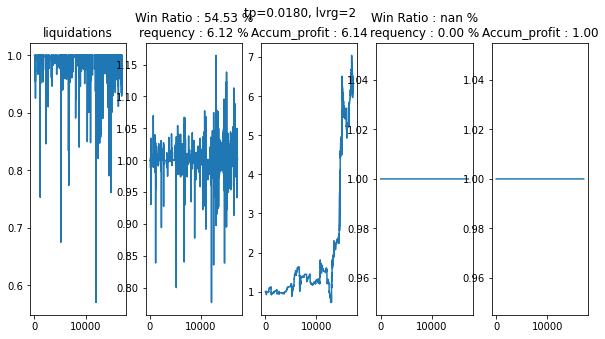

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (1049, 45, 6)


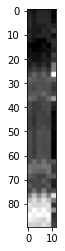

input_x.shape : (1049, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1049, 1)
input_ud.shape : (1049, 1)
input_index.shape : (1049, 1)
total_x.shape : (9946, 90, 12, 3)
total_pr.shape : (9946, 1)
total_ud.shape : (9946, 1)
prev_index.shape : (9946, 1)
ohlcv.head() :
                           open   high    low  close     volume
2020-04-17 00:29:59.999  2.010  2.025  2.007  2.017   339365.1
2020-04-17 00:59:59.999  2.016  2.053  2.010  2.051   778359.8
2020-04-17 01:29:59.999  2.050  2.081  2.039  2.041  2290142.9
2020-04-17 01:59:59.999  2.041  2.064  2.030  2.055   603526.3
2020-04-17 02:29:59.999  2.055  2.056  2.030  2.037   373219.9
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XTZUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

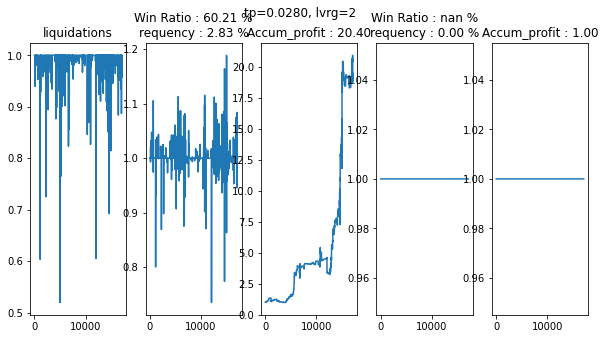

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (485, 45, 6)


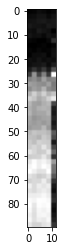

input_x.shape : (485, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (485, 1)
input_ud.shape : (485, 1)
input_index.shape : (485, 1)
total_x.shape : (10431, 90, 12, 3)
total_pr.shape : (10431, 1)
total_ud.shape : (10431, 1)
prev_index.shape : (10431, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-04-17 00:29:59.999  15.422  15.477  15.419  15.456   30907.46
2020-04-17 00:59:59.999  15.457  15.526  15.385  15.512   58515.93
2020-04-17 01:29:59.999  15.510  15.550  15.297  15.303  105785.98
2020-04-17 01:59:59.999  15.307  15.346  15.217  15.318   86557.19
2020-04-17 02:29:59.999  15.316  15.345  15.264  15.309   49189.04
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BNBUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

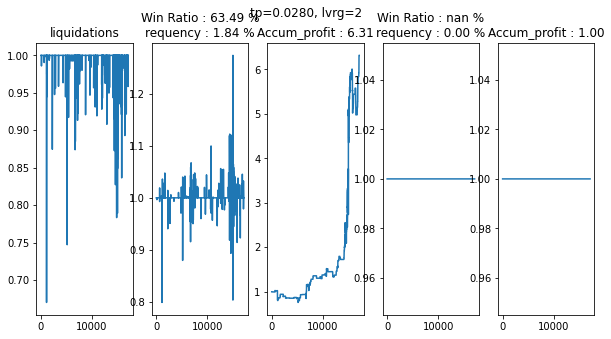

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (315, 45, 6)


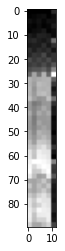

input_x.shape : (315, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (315, 1)
input_ud.shape : (315, 1)
input_index.shape : (315, 1)
total_x.shape : (10746, 90, 12, 3)
total_pr.shape : (10746, 1)
total_ud.shape : (10746, 1)
prev_index.shape : (10746, 1)
ohlcv.head() :
                           open   high    low  close     volume
2020-04-17 00:29:59.999  2.385  2.392  2.381  2.391   20733.45
2020-04-17 00:59:59.999  2.391  2.401  2.378  2.401   48238.08
2020-04-17 01:29:59.999  2.401  2.412  2.371  2.374  108071.79
2020-04-17 01:59:59.999  2.372  2.386  2.361  2.383   75229.09
2020-04-17 02:29:59.999  2.383  2.392  2.370  2.378   36656.58
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ATOMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

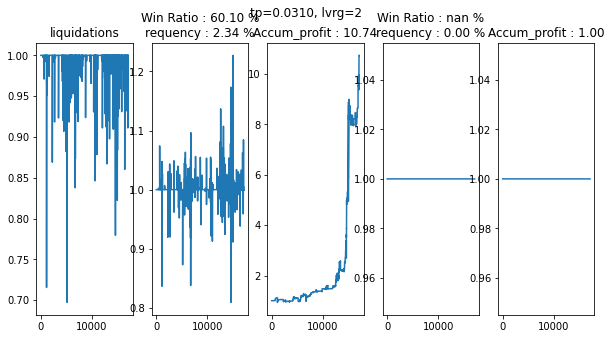

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (401, 45, 6)


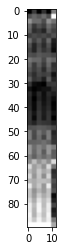

input_x.shape : (401, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (401, 1)
input_ud.shape : (401, 1)
input_index.shape : (401, 1)
total_x.shape : (11147, 90, 12, 3)
total_pr.shape : (11147, 1)
total_ud.shape : (11147, 1)
prev_index.shape : (11147, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-04-17 00:29:59.999  0.4033  0.4050  0.4030  0.4047   36965.3
2020-04-17 00:59:59.999  0.4046  0.4079  0.4032  0.4079  129291.3
2020-04-17 01:29:59.999  0.4079  0.4098  0.4021  0.4027  233853.8
2020-04-17 01:59:59.999  0.4023  0.4037  0.4007  0.4032  134557.3
2020-04-17 02:29:59.999  0.4032  0.4043  0.4016  0.4029   61413.2
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ONTUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

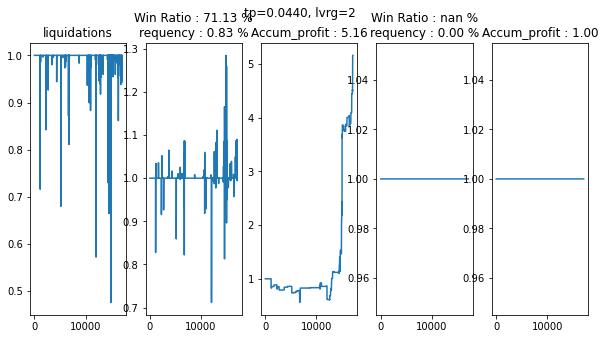

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (142, 45, 6)


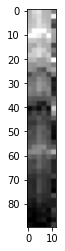

input_x.shape : (142, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (142, 1)
input_ud.shape : (142, 1)
input_index.shape : (142, 1)
total_x.shape : (11289, 90, 12, 3)
total_pr.shape : (11289, 1)
total_ud.shape : (11289, 1)
prev_index.shape : (11289, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-04-17 00:29:59.999  0.1557  0.1561  0.1554  0.1558   56067.1
2020-04-17 00:59:59.999  0.1558  0.1567  0.1552  0.1567  187281.3
2020-04-17 01:29:59.999  0.1566  0.1572  0.1547  0.1547  465163.4
2020-04-17 01:59:59.999  0.1548  0.1554  0.1540  0.1552  195905.0
2020-04-17 02:29:59.999  0.1552  0.1554  0.1544  0.1551   61257.9
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 IOTAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

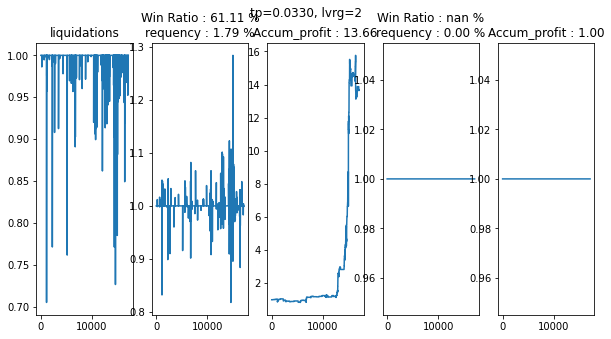

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (306, 45, 6)


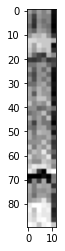

input_x.shape : (306, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (306, 1)
input_ud.shape : (306, 1)
input_index.shape : (306, 1)
total_x.shape : (11595, 90, 12, 3)
total_pr.shape : (11595, 1)
total_ud.shape : (11595, 1)
prev_index.shape : (11595, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-04-17 00:29:59.999  0.1633  0.1644  0.1633  0.1641  114492.5
2020-04-17 00:59:59.999  0.1639  0.1648  0.1626  0.1643  576648.3
2020-04-17 01:29:59.999  0.1643  0.1653  0.1629  0.1630  705363.3
2020-04-17 01:59:59.999  0.1631  0.1636  0.1623  0.1630  194388.7
2020-04-17 02:29:59.999  0.1631  0.1636  0.1626  0.1631   88868.4
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BATUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

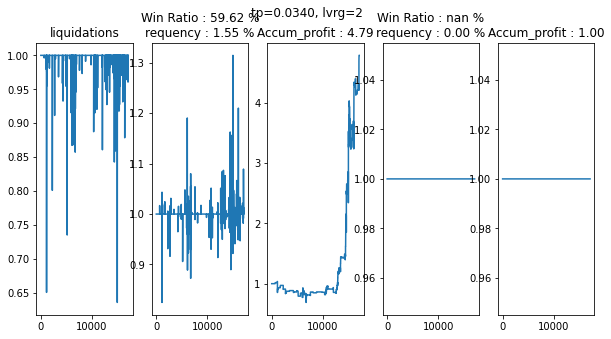

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (265, 45, 6)


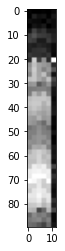

input_x.shape : (265, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (265, 1)
input_ud.shape : (265, 1)
input_index.shape : (265, 1)
total_x.shape : (11860, 90, 12, 3)
total_pr.shape : (11860, 1)
total_ud.shape : (11860, 1)
prev_index.shape : (11860, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-04-17 00:29:59.999  7.466  7.492  7.466  7.481   6422.25
2020-04-17 00:59:59.999  7.483  7.512  7.439  7.508  11971.35
2020-04-17 01:29:59.999  7.509  7.546  7.431  7.431  33245.67
2020-04-17 01:59:59.999  7.431  7.460  7.406  7.450   9549.07
2020-04-17 02:29:59.999  7.449  7.472  7.437  7.456   4676.18
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 NEOUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

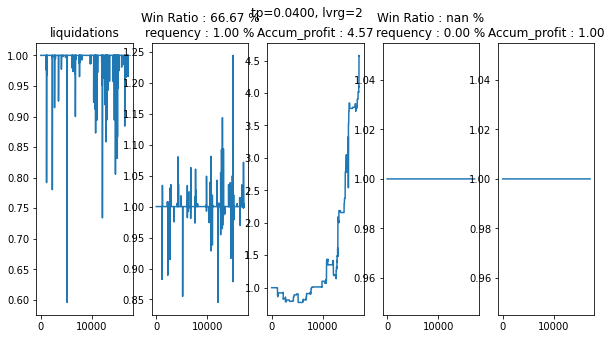

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (171, 45, 6)


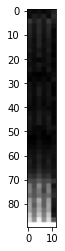

input_x.shape : (171, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (171, 1)
input_ud.shape : (171, 1)
input_index.shape : (171, 1)
total_x.shape : (12031, 90, 12, 3)
total_pr.shape : (12031, 1)
total_ud.shape : (12031, 1)
prev_index.shape : (12031, 1)
ohlcv.head() :
                           open   high    low  close   volume
2020-04-17 00:29:59.999  1.375  1.384  1.374  1.377  52796.9
2020-04-17 00:59:59.999  1.377  1.388  1.374  1.388  20423.0
2020-04-17 01:29:59.999  1.388  1.393  1.373  1.373  67634.4
2020-04-17 01:59:59.999  1.374  1.377  1.368  1.375  22448.5
2020-04-17 02:29:59.999  1.377  1.379  1.372  1.377   7296.4
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 QTUMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

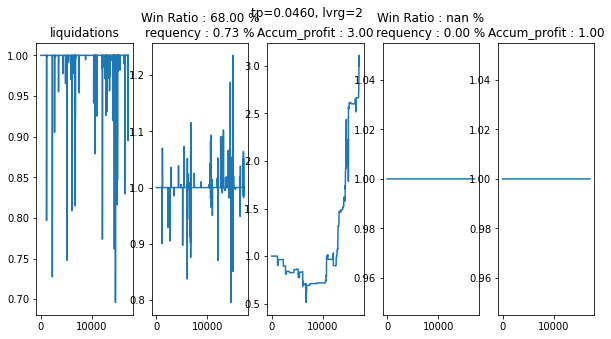

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (125, 45, 6)


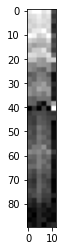

input_x.shape : (125, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (125, 1)
input_ud.shape : (125, 1)
input_index.shape : (125, 1)
total_x.shape : (12156, 90, 12, 3)
total_pr.shape : (12156, 1)
total_ud.shape : (12156, 1)
prev_index.shape : (12156, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-08-12 16:29:59.999  2.5000  2.5000  1.7000  1.9271  501241.6
2020-08-12 16:59:59.999  1.9313  2.0077  1.9053  1.9363  326247.0
2020-08-12 17:29:59.999  1.9363  2.0440  1.9363  2.0057  610682.1
2020-08-12 17:59:59.999  2.0057  2.0106  1.9485  1.9667  263744.0
2020-08-12 18:29:59.999  1.9667  2.0800  1.9488  2.0722  698980.2
ohlcv.index[0] : 2020-08-12 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 WAVESUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

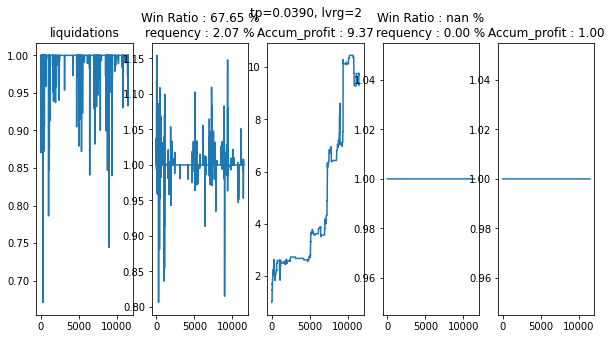

len(ohlc) : 11481
long_ep.shape : (11481, 1)
len(pr_list) : 11481
np.array(data_x).shape : (232, 45, 6)


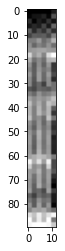

input_x.shape : (232, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (232, 1)
input_ud.shape : (232, 1)
input_index.shape : (232, 1)
total_x.shape : (12388, 90, 12, 3)
total_pr.shape : (12388, 1)
total_ud.shape : (12388, 1)
prev_index.shape : (12388, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-08-13 16:29:59.999  830.00  870.45  814.83  820.78  4258.931
2020-08-13 16:59:59.999  822.24  830.00  818.86  822.13  3288.322
2020-08-13 17:29:59.999  822.22  822.40  759.56  759.56  4167.521
2020-08-13 17:59:59.999  759.74  768.60  702.63  719.50  5682.920
2020-08-13 18:29:59.999  719.48  731.04  702.53  730.47  3976.159
ohlcv.index[0] : 2020-08-13 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 MKRUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

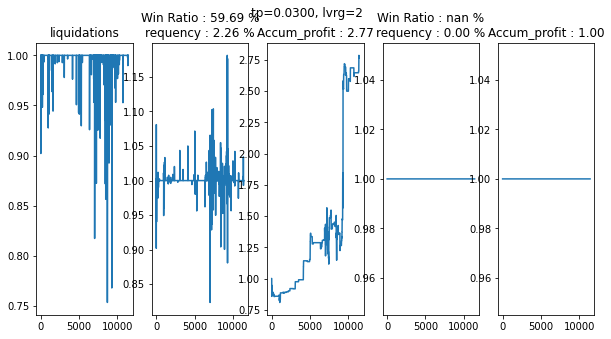

len(ohlc) : 11433
long_ep.shape : (11433, 1)
len(pr_list) : 11433
np.array(data_x).shape : (252, 45, 6)


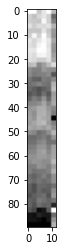

input_x.shape : (252, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (252, 1)
input_ud.shape : (252, 1)
input_index.shape : (252, 1)
total_x.shape : (12640, 90, 12, 3)
total_pr.shape : (12640, 1)
total_ud.shape : (12640, 1)
prev_index.shape : (12640, 1)
ohlcv.head() :
                           open   high    low  close    volume
2020-08-14 16:29:59.999  5.460  5.890  5.400  5.700  347498.0
2020-08-14 16:59:59.999  5.707  5.742  5.650  5.668  140832.4
2020-08-14 17:29:59.999  5.675  5.800  5.668  5.767  125310.2
2020-08-14 17:59:59.999  5.767  5.903  5.710  5.764  216978.6
2020-08-14 18:29:59.999  5.772  5.853  5.719  5.772  184144.4
ohlcv.index[0] : 2020-08-14 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 SNXUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

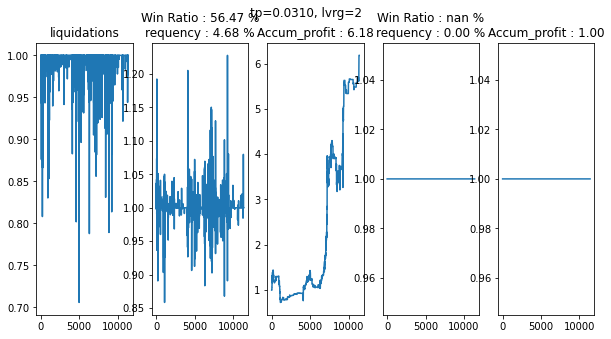

len(ohlc) : 11385
long_ep.shape : (11385, 1)
len(pr_list) : 11385
np.array(data_x).shape : (528, 45, 6)


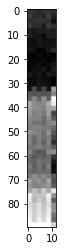

input_x.shape : (528, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (528, 1)
input_ud.shape : (528, 1)
input_index.shape : (528, 1)
total_x.shape : (13168, 90, 12, 3)
total_pr.shape : (13168, 1)
total_ud.shape : (13168, 1)
prev_index.shape : (13168, 1)
ohlcv.head() :
                           open   high    low  close     volume
2020-08-22 16:29:59.999  2.920  5.100  2.920  3.359  1302212.2
2020-08-22 16:59:59.999  3.382  3.696  3.303  3.423  1586689.9
2020-08-22 17:29:59.999  3.421  3.498  3.238  3.386   921023.8
2020-08-22 17:59:59.999  3.397  3.866  3.380  3.850  1760305.1
2020-08-22 18:29:59.999  3.839  3.927  3.567  3.759  1673089.6
ohlcv.index[0] : 2020-08-22 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 DOTUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

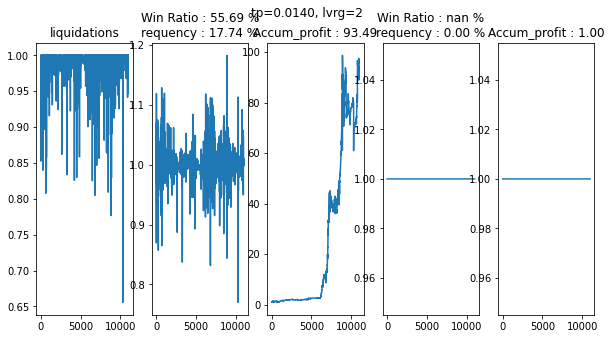

len(ohlc) : 11001
long_ep.shape : (11001, 1)
len(pr_list) : 11001
np.array(data_x).shape : (1922, 45, 6)


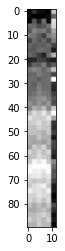

input_x.shape : (1922, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1922, 1)
input_ud.shape : (1922, 1)
input_index.shape : (1922, 1)
total_x.shape : (15090, 90, 12, 3)
total_pr.shape : (15090, 1)
total_ud.shape : (15090, 1)
prev_index.shape : (15090, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-05-27 17:29:59.999  0.4040  0.4442  0.3600  0.4298  5193846.8
2020-05-27 17:59:59.999  0.4301  0.4325  0.4240  0.4325  1706689.7
2020-05-27 18:29:59.999  0.4325  0.4330  0.4223  0.4277  1673620.0
2020-05-27 18:59:59.999  0.4277  0.4325  0.4262  0.4303  1081970.9
2020-05-27 19:29:59.999  0.4303  0.4510  0.4278  0.4490  4054612.6
ohlcv.index[0] : 2020-05-27 17:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 THETAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

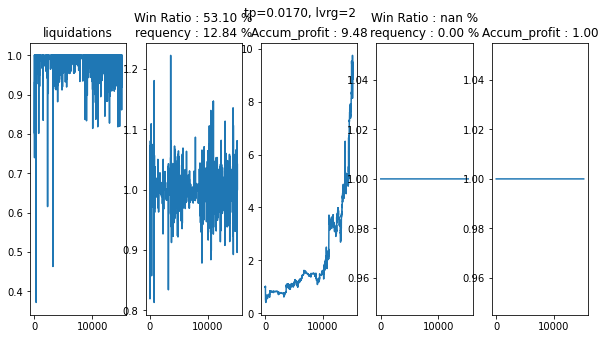

len(ohlc) : 15175
long_ep.shape : (15175, 1)
len(pr_list) : 15175
np.array(data_x).shape : (1923, 45, 6)


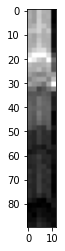

input_x.shape : (1923, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1923, 1)
input_ud.shape : (1923, 1)
input_index.shape : (1923, 1)
total_x.shape : (17013, 90, 12, 3)
total_pr.shape : (17013, 1)
total_ud.shape : (17013, 1)
prev_index.shape : (17013, 1)
ohlcv.head() :
                            open    high     low   close     volume
2020-06-16 18:29:59.999  0.2525  0.2890  0.2327  0.2374  3066947.5
2020-06-16 18:59:59.999  0.2374  0.2389  0.2336  0.2350  1132925.3
2020-06-16 19:29:59.999  0.2350  0.2373  0.2347  0.2367   472439.2
2020-06-16 19:59:59.999  0.2366  0.2382  0.2352  0.2375   351561.7
2020-06-16 20:29:59.999  0.2374  0.2388  0.2360  0.2360   610382.1
ohlcv.index[0] : 2020-06-16 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ALGOUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

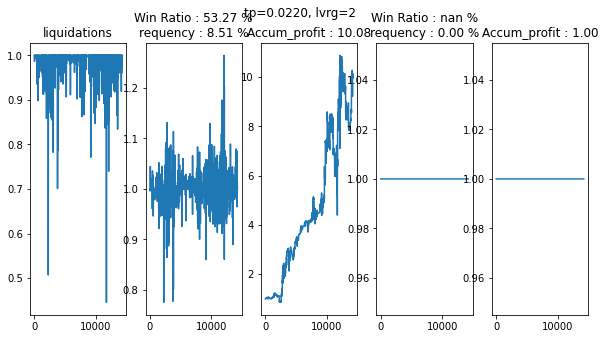

len(ohlc) : 14213
long_ep.shape : (14213, 1)
len(pr_list) : 14213
np.array(data_x).shape : (1208, 45, 6)


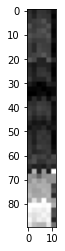

input_x.shape : (1208, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (1208, 1)
input_ud.shape : (1208, 1)
input_index.shape : (1208, 1)
total_x.shape : (18221, 90, 12, 3)
total_pr.shape : (18221, 1)
total_ud.shape : (18221, 1)
prev_index.shape : (18221, 1)
ohlcv.head() :
                             open     high      low    close  volume
2020-06-22 17:59:59.999  1.24500  1.24500  1.21433  1.24052   61737
2020-06-22 18:29:59.999  1.24052  1.27452  1.23938  1.25359  326120
2020-06-22 18:59:59.999  1.25359  1.25627  1.24200  1.24452  246526
2020-06-22 19:29:59.999  1.24450  1.24922  1.22693  1.23886  399629
2020-06-22 19:59:59.999  1.23938  1.24309  1.21997  1.22080  309375
ohlcv.index[0] : 2020-06-22 17:59:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 KNCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

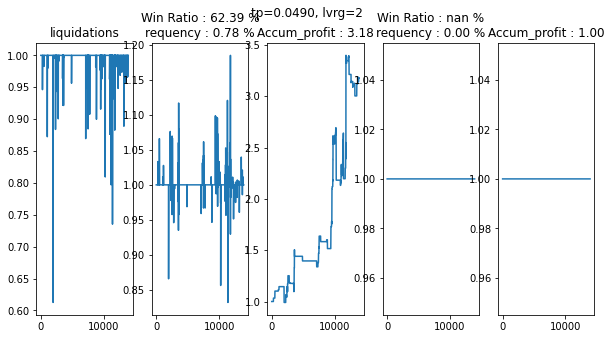

len(ohlc) : 13926
long_ep.shape : (13926, 1)
len(pr_list) : 13926
np.array(data_x).shape : (109, 45, 6)


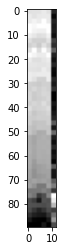

input_x.shape : (109, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (109, 1)
input_ud.shape : (109, 1)
input_index.shape : (109, 1)
total_x.shape : (18330, 90, 12, 3)
total_pr.shape : (18330, 1)
total_ud.shape : (18330, 1)
prev_index.shape : (18330, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-06-24 18:29:59.999  0.3620  0.3620  0.3499  0.3528  397185.3
2020-06-24 18:59:59.999  0.3528  0.3528  0.3485  0.3501  248072.8
2020-06-24 19:29:59.999  0.3502  0.3504  0.3476  0.3480  275954.4
2020-06-24 19:59:59.999  0.3479  0.3488  0.3401  0.3420  416596.9
2020-06-24 20:29:59.999  0.3421  0.3450  0.3421  0.3444  176269.0
ohlcv.index[0] : 2020-06-24 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ZRXUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

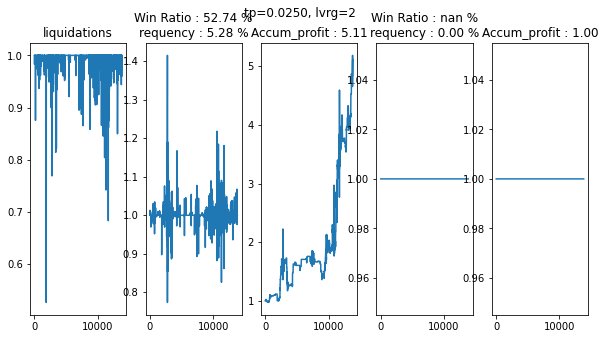

len(ohlc) : 13829
long_ep.shape : (13829, 1)
len(pr_list) : 13829
np.array(data_x).shape : (729, 45, 6)


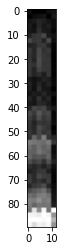

input_x.shape : (729, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (729, 1)
input_ud.shape : (729, 1)
input_index.shape : (729, 1)
total_x.shape : (19059, 90, 12, 3)
total_pr.shape : (19059, 1)
total_ud.shape : (19059, 1)
prev_index.shape : (19059, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-06-30 18:29:59.999  231.58  232.07  225.32  227.19  3769.975
2020-06-30 18:59:59.999  227.15  227.19  220.35  220.79  3546.389
2020-06-30 19:29:59.999  220.70  222.64  214.15  217.07  5964.534
2020-06-30 19:59:59.999  217.08  222.40  217.08  221.90  3526.760
2020-06-30 20:29:59.999  222.00  224.00  220.71  221.55  3792.355
ohlcv.index[0] : 2020-06-30 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 COMPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

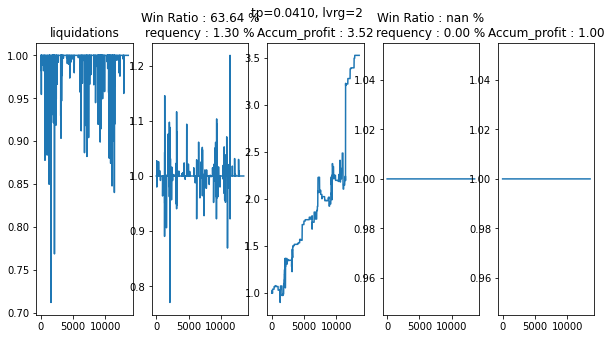

len(ohlc) : 13541
long_ep.shape : (13541, 1)
len(pr_list) : 13541
np.array(data_x).shape : (176, 45, 6)


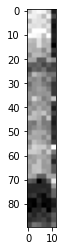

input_x.shape : (176, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (176, 1)
input_ud.shape : (176, 1)
input_index.shape : (176, 1)
total_x.shape : (19235, 90, 12, 3)
total_pr.shape : (19235, 1)
total_ud.shape : (19235, 1)
prev_index.shape : (19235, 1)
ohlcv.head() :
                            open    high     low   close    volume
2020-07-02 18:29:59.999  1.3775  1.4721  1.3520  1.4176  813855.5
2020-07-02 18:59:59.999  1.4178  1.4243  1.4047  1.4213  218483.1
2020-07-02 19:29:59.999  1.4214  1.4444  1.4186  1.4213  178867.2
2020-07-02 19:59:59.999  1.4210  1.4311  1.4166  1.4243  121892.4
2020-07-02 20:29:59.999  1.4244  1.4244  1.4100  1.4165   76131.2
ohlcv.index[0] : 2020-07-02 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 OMGUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

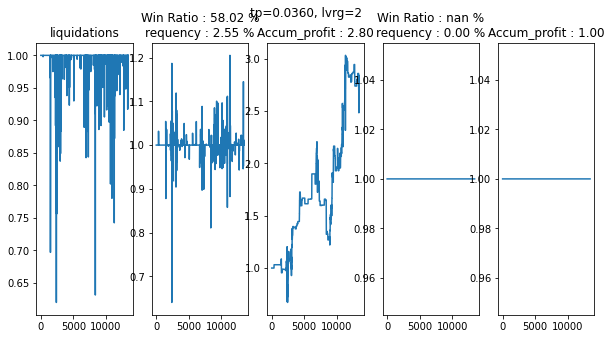

len(ohlc) : 13445
long_ep.shape : (13445, 1)
len(pr_list) : 13445
np.array(data_x).shape : (343, 45, 6)


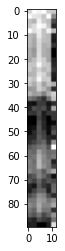

input_x.shape : (343, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (343, 1)
input_ud.shape : (343, 1)
input_index.shape : (343, 1)
total_x.shape : (19578, 90, 12, 3)
total_pr.shape : (19578, 1)
total_ud.shape : (19578, 1)
prev_index.shape : (19578, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split

with open('./arima_result/prev_close_candi_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

candis = list(load_dict.keys())
long_index = 0
leverage = 2
prev_x = None
total_x = None

seed = 1
random_state = 20
np.random.seed(seed)

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue
  if '2021-03-02 DOTUSDT.xlsx' in candis[i]:
    # print('')
    continue

  if '04-08' not in candis[i]:  # <-- 04-08 includes all timestamp range
    continue

  # if 'theta'.upper() not in candis[i]:
  #   continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(load_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = load_dict[key]['tp_list'][argmax]
  #   # plt.axvline(max_peak_tp, linestyle='--')
  #   # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = load_dict[key]['ohlcv']

      print("ohlcv.head() :\n", ohlcv.head())

      # ohlcv = ohlcv.iloc[:-int(len(ohlcv) * 0.3)]  # exclude back_range
      # predictions = load_dict[key]['predictions']
      # err_ranges = load_dict[key]['err_ranges']
      print("ohlcv.index[0] :", ohlcv.index[0])
      print("ohlcv.index[-1] :", ohlcv.index[-1])

      predictions = ohlcv['close'].shift(1).values
      err_ranges = np.zeros_like(predictions)

      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      try:
        print('-------------- %s --------------' % key)
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
        # temp_ap_list.append(result[2])
        # temp_pr_list.append(result[3])

        # if round(leverage) == 1:
        #   temp_pr_list = result[3]
        pr_list = result[3][long_index]

      except Exception as e:
        print(e)
        break    
  # break


      pd.set_option('display.max_rows', 500)
      pd.set_option('display.max_columns', 500)
      pd.set_option('display.width', 1000)

      #         clustering zone           #

      #       set data features : ohlc, v, ep
      time_index = ohlcv.index[-len(predictions):]
      ohlc = ohlcv.iloc[-len(predictions):, :4]
      vol = ohlcv.iloc[-len(predictions):, [4]]
      long_ep = np.array(predictions)
      long_ep = long_ep.reshape(-1, 1)

      ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
      ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
      ohlcv['body'] = ohlcv['close'] / ohlcv['open']

      candle = ohlcv.iloc[-len(predictions):, -3:]


      print('len(ohlc) :', len(ohlc))
      print('long_ep.shape :', long_ep.shape)
      print('len(pr_list) :', len(pr_list))


      #       set params    #
      period = 45
      data_x, data_pr, data_updown = [], [], []
      data_index = []
      key_i = i

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]
          temp_vol = vol.iloc[i - period : i].values
          temp_candle = candle.iloc[i - period : i].values

          # print(temp_ohlc.shape)
          # print(temp_long_ep.shape)
          # print(temp_vol.shape)
          # print(temp_candle.shape)
          # break

          #   stacking  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
          # temp_data = np.hstack((temp_ohlc, temp_vol))

          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          # max_abs = MaxAbsScaler()
          # temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


          min_max = MinMaxScaler()
          temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


          #   vol -> min_max
          min_max = MinMaxScaler()
          temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_index.append(time_index[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)

      #     1c to 3c    #
      input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      input_index = np.array(data_index).reshape(-1, 1)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)
      print('input_index.shape :', input_index.shape)


      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      if prev_x is None:
        prev_x = input_x
        prev_pr = input_pr
        prev_ud = input_ud
        prev_index = input_index
      else:
        total_x = np.vstack((prev_x, input_x))
        total_pr = np.vstack((prev_pr, input_pr))
        total_ud = np.vstack((prev_ud, input_ud)) 
        total_index = np.vstack((prev_index, input_index)) 

        prev_x = total_x
        prev_pr = total_pr
        prev_ud = total_ud
        prev_index = total_index

        print('total_x.shape :', total_x.shape)
        print('total_pr.shape :', total_pr.shape)
        print('total_ud.shape :', total_ud.shape)
        print('prev_index.shape :', prev_index.shape)

      # if prev_train_x is None:
      #   prev_train_x = x_train
      #   prev_val_x = x_val
      #   prev_test_x = x_test
        
      #   prev_train_pr = pr_train
      #   prev_val_pr = pr_val
      #   prev_test_pr = pr_test

      #   prev_train_ud = ud_train
      #   prev_val_ud = ud_val
      #   prev_test_ud = ud_test

      # else:

      #   total_train_x = np.vstack((prev_train_x, x_train))
      #   total_val_x = np.vstack((prev_val_x, x_val))
      #   total_test_x = np.vstack((prev_test_x, x_test))
      #   total_train_pr = np.vstack((prev_train_pr, pr_train))
      #   total_val_pr = np.vstack((prev_val_pr, pr_val))
      #   total_test_pr = np.vstack((prev_test_pr, pr_test))
      #   total_train_ud = np.vstack((prev_train_ud, ud_train))
      #   total_val_ud = np.vstack((prev_val_ud, ud_val))
      #   total_test_ud = np.vstack((prev_test_ud, ud_test))
        
      #   prev_train_x = total_train_x
      #   prev_val_x = total_val_x
      #   prev_test_x = total_test_x
        
      #   prev_train_pr = total_train_pr
      #   prev_val_pr = total_val_pr
      #   prev_test_pr = total_test_pr

      #   prev_train_ud = total_train_ud
      #   prev_val_ud = total_val_ud
      #   prev_test_ud = total_test_ud
        
      #   print("total_train_x.shape :", total_train_x.shape)
      #   print("total_val_x.shape :", total_val_x.shape)
      #   print("total_test_x.shape :", total_test_x.shape)
      #   print("total_train_pr.shape :", total_train_pr.shape)
      #   print("total_val_pr.shape :", total_val_pr.shape)
      #   print("total_test_pr.shape :", total_test_pr.shape)
      #   print("total_train_ud.shape :", total_train_ud.shape)
      #   print("total_val_ud.shape :", total_val_ud.shape)
      #   print("total_test_ud.shape :", total_test_ud.shape)

  # break # --> use only one pair dataset

  #         chunks 로 나누지 않아도, generator 에서 batch_size 만큼만 load 할 것   #
  try:
    if len(total_x) > 300000:
      break
  except:
    pass

  
        

In [10]:
period = 45
# x_save_path = current_path + 'npy/' + '%s_close_updown_x.npy' % period
# y_save_path = current_path + 'npy/' + '%s_close_updown_y.npy' % period
#         save to npy     #
# x_save_path = current_path + 'npy/' + '%s_close_updown_theta_x_ex.npy' % period
# y_save_path = current_path + 'npy/' + '%s_close_updown_theta_y_ex.npy' % period

# total_x = np.load(x_save_path)
# total_pr = np.load(y_save_path)

# _, row, col, _ = total_x.shape

_, row, col, _ = input_x.shape

#       split new test      #

seed = 1
random_state = 20
np.random.seed(seed)
from sklearn.model_selection import train_test_split
#         train / test split      #
# x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(re_input_x, input_pr, input_ud, test_size=0.4, shuffle=True, random_state=random_state)
# x_train_, x_test, pr_train_, pr_test = train_test_split(total_x, total_pr, test_size=0.2, shuffle=False, random_state=random_state)
# x_train, x_val, pr_train, pr_val = train_test_split(x_train_, pr_train_, test_size=0.25, shuffle=True, random_state=random_state)
# break
# print("input_x.shape : ", input_x.shape)

# # # a_input_x, new_input_x, a_input_pr, new_input_pr, a_input_index, new_input_index = train_test_split(input_x, input_pr, input_index, test_size=0.3, shuffle=False, random_state=random_state)
a_input_x, new_input_x, a_input_pr, new_input_pr, a_input_index, new_input_index = train_test_split(total_x, total_pr, total_index, test_size=0.05, shuffle=False, random_state=random_state)

# print("a_input_x.shape : ", a_input_x.shape)      

# even_input_x = a_input_x[::2]
# x_test = a_input_x[1::2]
# even_input_pr = a_input_pr[::2]
# pr_test = a_input_pr[1::2]
# even_input_index = a_input_index[::2]
# index_test = a_input_index[1::2]

# x_train_, x_test, pr_train_, pr_test, index_train_, index_test = train_test_split(input_x, input_pr, input_index, test_size=0.3, shuffle=True, random_state=random_state)
# x_train_, x_test, pr_train_, pr_test, index_train_, index_test = train_test_split(total_x, total_pr, total_index, test_size=0.3, shuffle=True, random_state=random_state)
x_train_, x_test, pr_train_, pr_test, index_train_, index_test = train_test_split(a_input_x, a_input_pr, a_input_index, test_size=0.2, shuffle=True, random_state=random_state)

# print("x_train_.shape :", x_train_.shape) # with a_input_x -> 4263 / with input_x -> 4219

#           extract prev data           #
#           test data 의 짝수차 데이터를 train set 에 넘기고, train & val split 을 shuffle 로 진행한다
# print('org x_test.shape :', x_test.shape)
# x_test4train, pr_test4train, index_test4train =  x_test[::2], pr_test[::2], index_test[::2]
# x_test, pr_test, index_test =  x_test[1::2], pr_test[1::2], index_test[1::2]
# print('divided x_test.shape :', x_test.shape)
# print()


#          add test4train data to training set      #
# x_train_ = np.vstack((x_train_, x_test4train))
# pr_train_ = np.vstack((pr_train_, pr_test4train))
# index_train_ = np.vstack((index_train_, index_test4train))

# print("x_test4train.shape :", x_test4train.shape) 
# print("added x_train_.shape :", x_train_.shape) # with a_input_x -> 4263 / with input_x -> 4219

# print("x_train_.shape :", x_train_.shape) # x_train.shape : (3807, 90, 12, 3)

# x_train_, x_test, pr_train_, pr_test = train_test_split(input_x, input_pr, test_size=0.4, shuffle=True, random_state=random_state)
# x_train, x_val, pr_train, pr_val, index_train, index_val = train_test_split(even_input_x, even_input_pr, even_input_index, test_size=0.25, shuffle=True, random_state=random_state)
x_train, x_val, pr_train, pr_val, index_train, index_val = train_test_split(x_train_, pr_train_, index_train_, test_size=0.3, shuffle=True, random_state=random_state)

#         pr label   #
# y_train = np.where(pr_train > 1, 1, 0)
# y_test = np.where(pr_test > 1, 1, 0)
# y_val = np.where(pr_val > 1, 1, 0)

print("new_input_x.shape :", new_input_x.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

# del total_x

new_input_x.shape : (979, 90, 12, 3)
x_train.shape : (10415, 90, 12, 3)
x_val.shape : (4464, 90, 12, 3)
x_test.shape : (3720, 90, 12, 3)


In [13]:
x_save_path = current_path + 'npy/' + '%s_prev_close_x_train.npy' % period
np.save(x_save_path, x_train)
np.save(x_save_path.replace('x_train', 'x_val'), x_val)
np.save(x_save_path.replace('x_train', 'x_test'), x_test)
np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
print('x series saved !')

pr_save_path = current_path + 'npy/' + '%s_prev_close_pr_train.npy' % period
np.save(pr_save_path, pr_train)
np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
print('pr series saved !')


x series saved !
pr series saved !


### Check shuffled index

In [6]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

NameError: ignored

### Load Data

In [5]:
period = 45

x_save_path = current_path + 'npy/' + '%s_prev_close_x_train.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
new_input_x = np.load(x_save_path.replace('x_train', 'new_input_x'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_prev_close_pr_train.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
new_input_pr = np.load(pr_save_path.replace('pr_train', 'new_input_pr'))
print('y series loaded !')

_, row, col, _ = x_train.shape



x series loaded !
y series loaded !


In [ ]:
# period = 45
# # x_save_path = current_path + 'npy/' + '%s_close_updown_x.npy' % period
# # y_save_path = current_path + 'npy/' + '%s_close_updown_y.npy' % period
# #         save to npy     #
# x_save_path = current_path + 'npy/' + '%s_close_updown_theta_x_ex.npy' % period
# y_save_path = current_path + 'npy/' + '%s_close_updown_theta_y_ex.npy' % period

# total_x = np.load(x_save_path)
# total_pr = np.load(y_save_path)

# _, row, col, _ = total_x.shape



# seed = 1
# random_state = 20
# np.random.seed(seed)
# from sklearn.model_selection import train_test_split
# #         train / test split      #
# # x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(re_total_x, total_pr, total_ud, test_size=0.4, shuffle=True, random_state=random_state)
# x_train_, x_test, pr_train_, pr_test = train_test_split(total_x, total_pr, test_size=0.2, shuffle=False, random_state=random_state)
# x_train, x_val, pr_train, pr_val = train_test_split(x_train_, pr_train_, test_size=0.25, shuffle=False, random_state=random_state)
# # break
# #         pr label   #
# y_train = np.where(pr_train > 1, 1, 0)
# y_test = np.where(pr_test > 1, 1, 0)
# y_val = np.where(pr_val > 1, 1, 0)

# del total_x

### **Model**

In [7]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

%tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape=(row, col, 3)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

TensorFlow 1.x selected.


Using TensorFlow backend.


In [8]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

y_train[:5] : [[0]
 [0]
 [0]
 [1]
 [1]]
y_train.dtype : int64
x_train.shape : (10415, 90, 12, 3)
x_test.shape : (3720, 90, 12, 3)
x_val.shape : (4464, 90, 12, 3)
y_train.shape : (10415, 1)
y_test.shape : (3720, 1)
y_val.shape : (4464, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([4403, 6012])) [0.7323686 1.       ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([1866, 2598])) [0.7182448 1.       ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([1598, 2122])) [0.75306315 1.        ]
class_weights : {0: 1.1827163297751533, 1: 0.8661842980705257}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (10415, 2)
y_val_ohe.shape : (4464, 2)
y_test_ohe.shape : (3720, 2)


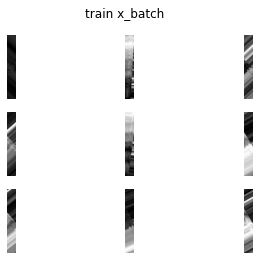

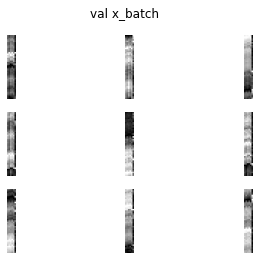

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight
# import cv2


_, row, col, _ = x_train.shape

#         pr label   #
y_train = np.where(pr_train > 1, 1, 0)
y_test = np.where(pr_test > 1, 1, 0)
y_val = np.where(pr_val > 1, 1, 0)


seed = 1
random_state = 20
np.random.seed(seed)
# tf.random.set_seed(seed)

#         up label      #
# y_train = np.where(ud_train > 1, 1, 0)
# y_test = np.where(ud_test > 1, 1, 0)
# y_val = np.where(ud_val > 1, 1, 0)

# print('pr_train[:5] :', pr_train[:5])
# print('ud_train[:5] :', ud_train[:5])
print('y_train[:5] :', y_train[:5])
print('y_train.dtype :', y_train.dtype)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

def class_ratio(in_list):

  return in_list / in_list[1]

print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)

datagen = ImageDataGenerator( 
    rotation_range = 45,
    # zoom_range = 0.5,
    # shear_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    # fill_mode = 'nearest'
    )

valgen = ImageDataGenerator( 
    )

datagen.fit(x_train)
valgen.fit(x_val)

batch_size = 16

for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

    plt.suptitle("train x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break

for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

    plt.suptitle("val x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break
    
train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
# break



### **Training**

In [18]:
(_, row, col, _) = x_train.shape
  
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
# model_name = 'classifier_%s_close_updown_pr_theta_shuffle_without_back_03.h5' % period
# model_name = 'classifier_%s_close_updown_pr_theta_train_prevdata_005.h5' % period

# model_name = 'classifier_%s_close_updown_pr_theta_train_evendata_shuffle2_300k.h5' % period
# model = keras.models.load_model(ckpt_path + model_name)


model = FER_Model(input_shape=(row, col, 3))
opt = Adam(lr=0.00001, decay=0.000005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_name = 'classifier_%s_prev_close_survey_pr_all_pair.h5' % period


checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=40)
# callbacks_list = [checkpoint, checkpoint2, checkpoint3]
callbacks_list = [checkpoint, checkpoint2]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(x_val) / batch_size,
                    shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Epoch 1/1000
 - 17s - loss: 0.7604 - accuracy: 0.5057 - val_loss: 0.8037 - val_accuracy: 0.4182

Epoch 00001: val_loss improved from inf to 0.80371, saving model to /content/drive/My Drive/Colab Notebooks/Project_Stock/ckpt/classifier_45_prev_close_survey_pr_all_pair.h5

Epoch 2/1000
 - 14s - loss: 0.7134 - accuracy: 0.5078 - val_loss: 0.6665 - val_accuracy: 0.5569

Epoch 00002: val_loss improved from 0.80371 to 0.66646, saving model to /content/drive/My Drive/Colab Notebooks/Project_Stock/ckpt/classifier_45_prev_close_survey_pr_all_pair.h5
Epoch 3/1000
 - 14s - loss: 0.6977 - accuracy: 0.5201 - val_loss: 0.6918 - val_accuracy: 0.5688

Epoch 00003: val_loss did not improve from 0.66646
Epoch 4/1000
 - 14s - loss: 0.6973 - accuracy: 0.5203 - val_loss: 0.7087 - val_accuracy: 0.5616

Epoch 00004: val_loss did not improve from 0.66646
Epoch 5/1000
 - 14s - loss: 0.6939 - accuracy: 0.5301 - val_loss: 0.7117 

KeyboardInterrupt: ignored

In [11]:
ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
# model_name = 'classifier_45_close_updown_pr_theta_non_shuffle_ex_02008.h5'
# model_name = 'classifier_45_close_updown_pr_theta.h5'
# model_name = 'classifier_45_close_updown_pr_theta_train_evendata_shuffle2_300k.h5'
model_name = 'classifier_45_prev_close_survey_pr_all_pair.h5'

model = keras.models.load_model(ckpt_path + model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [21]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [22]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [12]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

In [14]:
# x_test = new_input_x
# y_test = np.where(new_input_pr > 1, 1, 0)
# pr_test = new_input_pr

# x_test = org_x_test
# y_test = org_y_test
# pr_test = org_pr_test

# x_test = x_train
# y_test = y_train
# pr_test = pr_train

# x_test = x_val
# y_test = y_val
# pr_test = pr_val

# x_test = concat_x
# y_test = np.where(concat_pr > 1, 1, 0)
# pr_test = concat_pr

test_result = model.predict(x_test)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
# print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


# threshold = [0.65]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
new_thresh = []

for thresh in threshold:
  
  # if thresh < 0.6:
  #     continue

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  print('precision :', precision_score(y_test, y_pred))
  print('recall :', recall_score(y_test, y_pred))
  print()

  print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # plt.show()  
  print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  pred_pr_list = np.where(pred_pr_list == np.nan, 1.0, pred_pr_list)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    print('thresh :', thresh)
    
  # if len(threshold) == 1:
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(test_pr_list))
    plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # plt.show()

    plt.subplot(122)
    plt.plot(np.cumprod(pred_pr_list))
    plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    plt.axvline(len(test_pr_list), linestyle='--', color='r')
    plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
  new_thresh.append(thresh)


print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

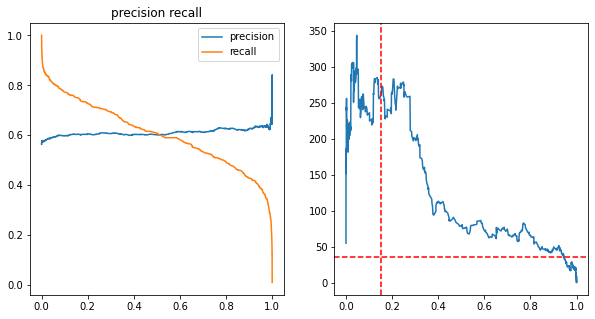

In [20]:

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
# plt.axvline(new_thresh[np.argmax(acc_pr_bythr)], linestyle='--', color='r')
plt.axvline(0.15, linestyle='--', color='r')
plt.show()

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

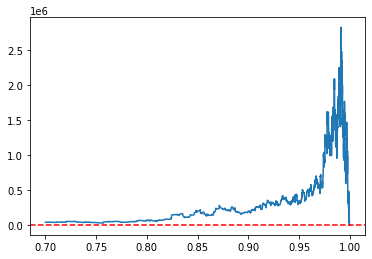

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

